In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Merge these two dataframes along the stay_id column.
df=pd.read_csv('train.csv')


In [6]:
#First look at the data.
df.describe()

,subject_id,hadm_id,stay_id,admission_age,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,stay_length_hours,pain_cleaned_advanced
count,3.702000e+05,1.813160e+05,3.702000e+05,370135.000000,348997.000000,355042.000000,352180.000000,351956.000000,354015.000000,353235.000000,364017.000000,370200.000000,346379.000000
mean,1.500807e+07,2.498954e+07,3.499598e+07,53.034725,98.087970,85.053128,17.562076,98.371309,134.971876,77.887429,2.616501,7.245178,4.319138
std,2.879698e+06,2.889761e+06,2.888004e+06,20.609713,0.975101,18.104575,2.542687,2.467737,22.770980,23.605273,0.709251,6.578481,3.819368
min,1.000003e+07,2.000002e+07,3.000001e+07,18.000000,82.400000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,1.251546e+07,2.248130e+07,3.249741e+07,35.000000,97.600000,72.000000,16.000000,97.000000,120.000000,68.000000,2.000000,3.608056,0.000000
50%,1.501261e+07,2.498706e+07,3.499177e+07,54.000000,98.000000,84.000000,18.000000,99.000000,133.000000,77.000000,3.000000,5.533333,5.000000
75%,1.750291e+07,2.748763e+07,3.750343e+07,69.000000,98.600000,96.000000,18.000000,100.000000,148.000000,87.000000,3.000000,8.398958,8.000000
max,1.999999e+07,2.999981e+07,3.999996e+07,91.000000,110.000000,1228.000000,209.000000,100.000000,960.000000,998.000000,5.000000,192.566667,10.000000


In [7]:
len(df)

370200

In [8]:
df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'gender',
       'race', 'arrival_transport', 'language', 'admission_age', 'temperature',
       'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity',
       'chiefcomplaint', 'stay_length_hours', 'pain_cleaned_advanced',
       'race_condensed'],
      dtype='object')

In [9]:
#Check how many missing values there are for each variable. 
df.isna().sum()

subject_id                    0
hadm_id                  188884
stay_id                       0
intime                        0
outtime                       0
gender                        0
race                          0
arrival_transport             0
language                  88514
admission_age                65
temperature               21203
heartrate                 15158
resprate                  18020
o2sat                     18244
sbp                       16185
dbp                       16965
pain                      11419
acuity                     6183
chiefcomplaint               15
stay_length_hours             0
pain_cleaned_advanced     23821
race_condensed             5889
dtype: int64

In [10]:
#Investigate this more by checking how these missing values are distributed. The following compute the number of missing values 
# in each row and then looks at the distribution of this count. It appears that for all but 4 cases, we have at least partial information
# for the triage variables. This makes it reasonble to do some kind of imputation here.
df.isna().sum(axis=1).value_counts()

0     152990
1     106021
2      88858
3       5729
9       3910
7       3285
8       2710
10      1857
6       1734
4       1448
11       784
5        586
12       288
Name: count, dtype: int64

In [28]:
df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'gender',
       'race', 'arrival_transport', 'language', 'admission_age', 'temperature',
       'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity',
       'chiefcomplaint', 'stay_length_hours', 'pain_cleaned_advanced',
       'race_condensed'],
      dtype='object')

In [32]:
print(df[['stay_id', 'gender','arrival_transport', 'language', 'admission_age', 'temperature',
       'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'acuity',
       'chiefcomplaint', 'stay_length_hours', 'pain_cleaned_advanced',
       'race_condensed']].isnull().any(axis=1).sum())
print(df[['stay_id', 'gender','arrival_transport', 'temperature',
       'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'acuity',
       'chiefcomplaint', 'stay_length_hours', 'pain_cleaned_advanced',
       'race_condensed']].isnull().any(axis=1).sum())

123215
41581


,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
F,200939.0,7.249344,6.372115,0.0,3.696389,5.600000,8.383333,178.666667
M,169261.0,7.240234,6.815377,0.0,3.516667,5.450278,8.400000,192.566667


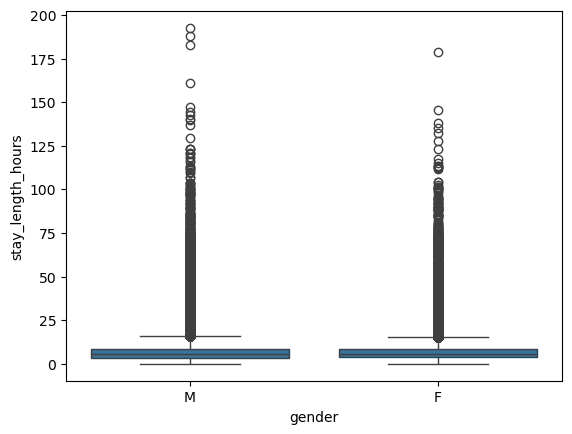

In [11]:
#Looking at stay length, grouped by gender. 

sns.boxplot(x='gender',y='stay_length_hours', data=df)
df.groupby('gender')['stay_length_hours'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
AMERICAN INDIAN/ALASKA NATIVE,917.0,7.725254,7.905772,0.050000,3.700000,5.583333,8.516667,81.916667
ASIAN,6443.0,6.431651,6.268804,0.083333,3.116667,4.850000,7.400000,123.133333
ASIAN - ASIAN INDIAN,1356.0,6.535657,5.895348,0.000000,3.179167,5.016667,7.604167,58.950000
ASIAN - CHINESE,6517.0,6.871851,5.775337,0.016667,3.550000,5.416667,8.100000,75.583333
ASIAN - KOREAN,706.0,6.022873,5.333504,0.066667,3.033333,4.716667,7.195833,62.766667
ASIAN - SOUTH EAST ASIAN,1365.0,7.162864,5.902574,0.116667,3.716667,5.466667,8.366667,52.566667
BLACK/AFRICAN,4249.0,7.270806,6.915779,0.050000,3.433333,5.333333,8.383333,117.200000
BLACK/AFRICAN AMERICAN,66037.0,7.421318,7.024135,0.000000,3.600000,5.583333,8.600000,188.100000
BLACK/CAPE VERDEAN,6711.0,6.541456,5.316736,0.116667,3.466667,5.233333,7.716667,77.050000


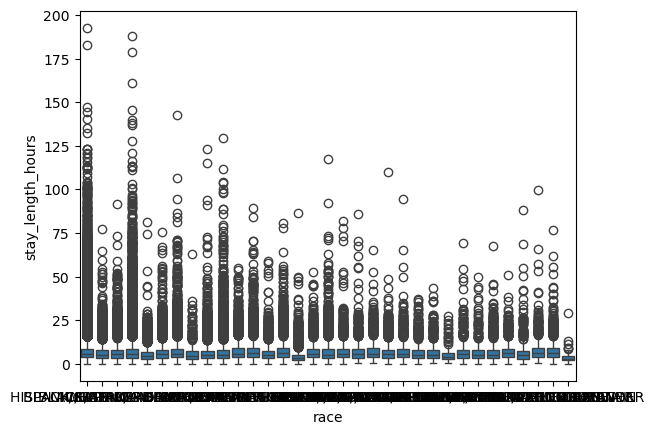

In [12]:
#Looking at stay length, grouped by race. There does seem to be substantial variation across racial categories, 
# but it does not line up nicely with the hierarchy of the categories. For example, note that stay lengths are shorter, generally for "Hispanic or Latino" 
#compareed to the various 'Hispanic/Latino' subcategories.
sns.boxplot(x='race',y='stay_length_hours', data=df)
df.groupby('race')['stay_length_hours'].describe()

,count,mean,std,min,25%,50%,75%,max
race_condensed,,,,,,,,
AMERICAN INDIAN/ALASKA NATIVE,917.0,7.725254,7.905772,0.050000,3.700000,5.583333,8.516667,81.916667
ASIAN,16387.0,6.658619,5.982431,0.000000,3.303056,5.133333,7.783333,123.133333
BLACK,80243.0,7.341927,6.857728,0.000000,3.583333,5.550000,8.533333,188.100000
HISPANIC/LATINO,29893.0,7.077610,6.218265,0.000000,3.583333,5.483333,8.266667,142.766667
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,444.0,6.855886,6.330782,0.033333,3.376458,5.050000,7.812500,49.816667
OTHER,20674.0,6.789573,6.324431,0.000000,3.383333,5.200000,7.833333,129.400000
White,215753.0,7.400722,6.608291,0.000000,3.733333,5.666667,8.533333,192.566667


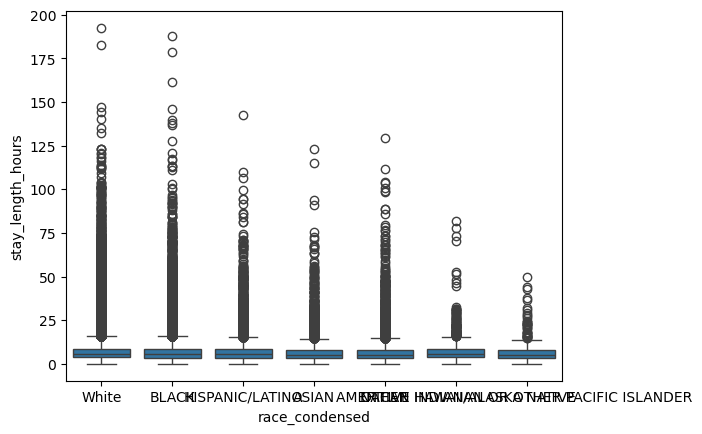

In [13]:
sns.boxplot(x='race_condensed',y='stay_length_hours', data=df)
df.groupby('race_condensed')['stay_length_hours'].describe()

,count,mean,std,min,25%,50%,75%,max
arrival_transport,,,,,,,,
AMBULANCE,137975.0,8.359990,7.329727,0.000000,4.283333,6.350000,9.616667,161.283333
HELICOPTER,780.0,4.660233,3.514314,0.200000,2.562500,3.825000,5.650000,29.700000
OTHER,1113.0,8.108707,10.154655,0.417222,3.316667,5.439722,8.550000,188.100000
UNKNOWN,8368.0,3.740110,3.418649,0.000000,1.723889,3.166667,4.966667,79.100000
WALK IN,221964.0,6.689095,6.017449,0.000000,3.350000,5.166667,7.783333,192.566667


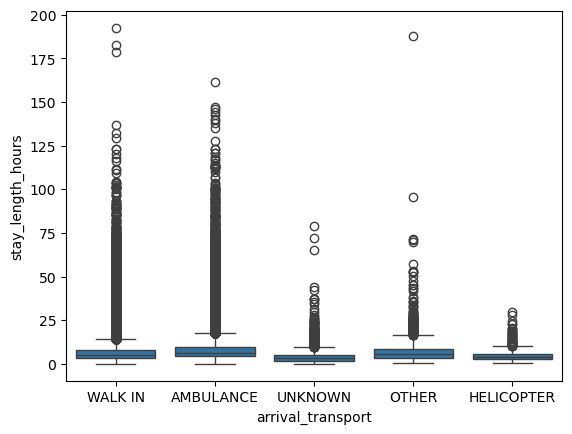

In [14]:
#Looking at stay length, grouped by arrival transport. There are significant differences here.
sns.boxplot(x='arrival_transport',y='stay_length_hours', data=df)
df.groupby('arrival_transport')['stay_length_hours'].describe()

,count,mean,std,min,25%,50%,75%,max
acuity,,,,,,,,
1.0,21420.0,6.064882,4.956279,0.0,3.333333,4.883333,7.144375,111.666667
2.0,122959.0,8.629886,7.888334,0.0,4.351944,6.400000,9.666667,192.566667
3.0,194345.0,7.073043,5.875938,0.0,3.716667,5.566667,8.283333,182.605556
4.0,24387.0,3.527073,3.538230,0.0,1.866667,2.750000,4.049583,113.016667
5.0,906.0,2.418038,2.900365,0.0,1.016667,1.833333,2.816667,36.716667


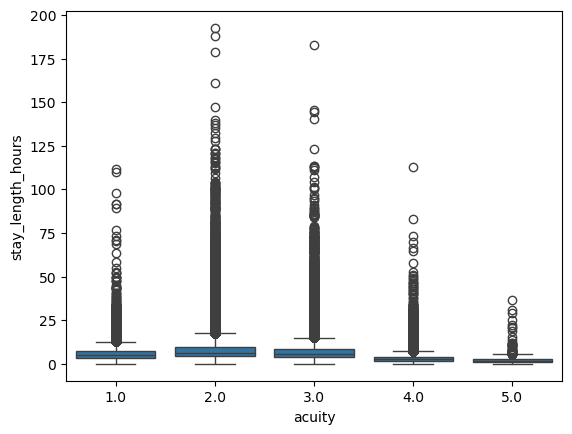

In [15]:
#Acuity is a ranking by a registered nurse based on the Emergency Severity Index (ESI). See details here: https://mimic.mit.edu/docs/iv/modules/ed/triage/ 
#It looks like this has a reasonably strong (but not monotonic) relationship.
sns.boxplot(x='acuity',y='stay_length_hours', data=df)
df.groupby('acuity')['stay_length_hours'].describe()

,count,mean,std,min,25%,50%,75%,max
pain,,,,,,,,
6-9,1.0,7.433333,NaN,7.433333,7.433333,7.433333,7.433333,7.433333
0,9.0,8.328642,7.345726,2.094167,5.000000,5.350000,8.233333,25.866667
10,3.0,5.855556,1.879741,4.600000,4.775000,4.950000,6.483333,8.016667
4,1.0,5.383333,NaN,5.383333,5.383333,5.383333,5.383333,5.383333
6,2.0,6.966667,3.252691,4.666667,5.816667,6.966667,8.116667,9.266667
...,...,...,...,...,...,...,...,...
yelling,1.0,5.831944,NaN,5.831944,5.831944,5.831944,5.831944,5.831944
yes,96.0,8.222274,5.733860,0.833333,4.300069,6.975000,9.662500,29.366667
yes,1.0,11.733333,NaN,11.733333,11.733333,11.733333,11.733333,11.733333


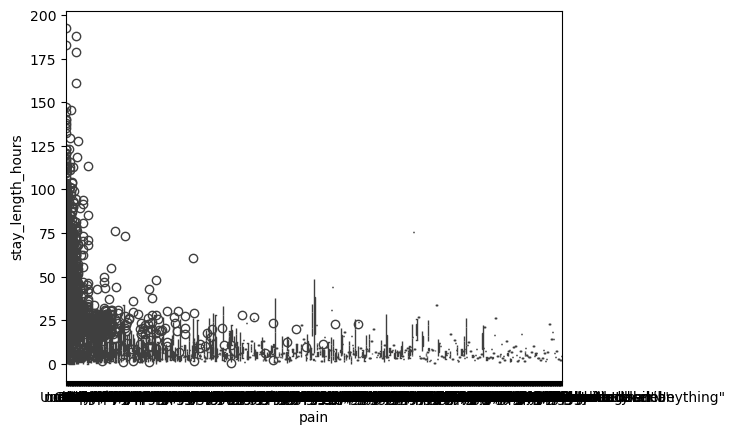

In [16]:
sns.boxplot(x='pain',y='stay_length_hours', data=df)
df.groupby('pain')['stay_length_hours'].describe()

<Axes: xlabel='temperature', ylabel='stay_length_hours'>

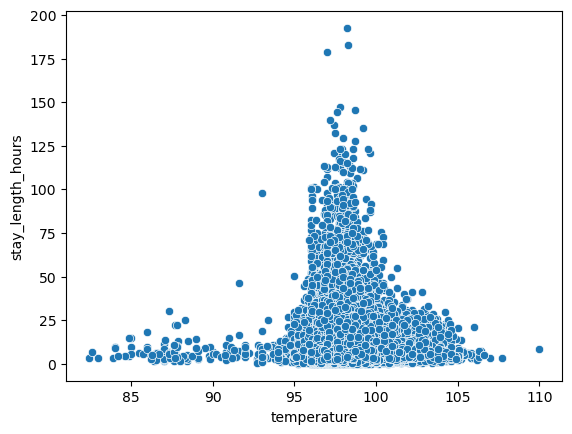

In [17]:
sns.scatterplot(x="temperature",
                    y="stay_length_hours",
                    data=df)

<Axes: xlabel='heartrate', ylabel='stay_length_hours'>

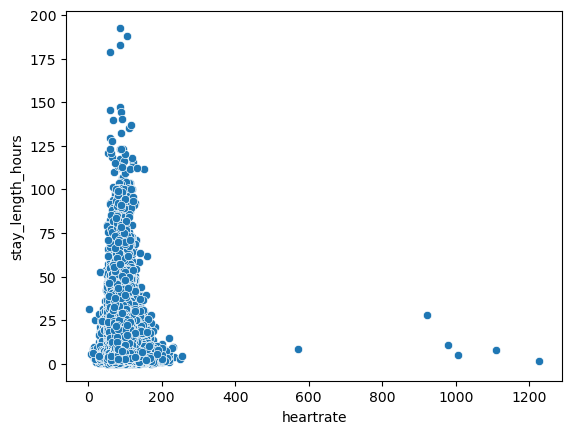

In [18]:
sns.scatterplot(x="heartrate",
                    y="stay_length_hours",
                    data=df)

<Axes: xlabel='resprate', ylabel='stay_length_hours'>

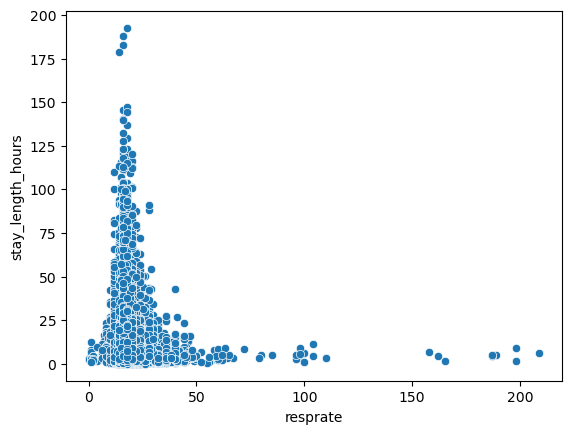

In [19]:
sns.scatterplot(x="resprate",
                    y="stay_length_hours",
                    data=df)

<Axes: xlabel='o2sat', ylabel='stay_length_hours'>

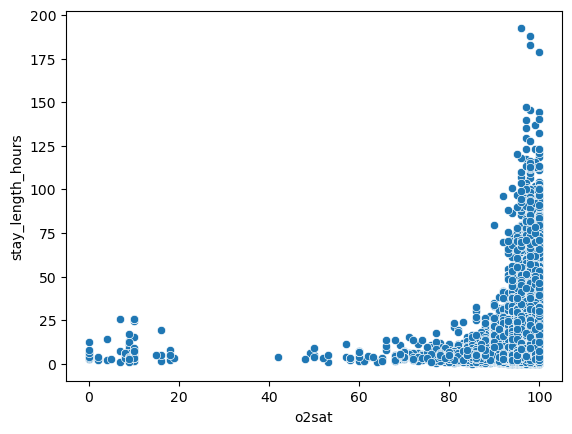

In [20]:
sns.scatterplot(x="o2sat",
                    y="stay_length_hours",
                    data=df)

<Axes: xlabel='sbp', ylabel='stay_length_hours'>

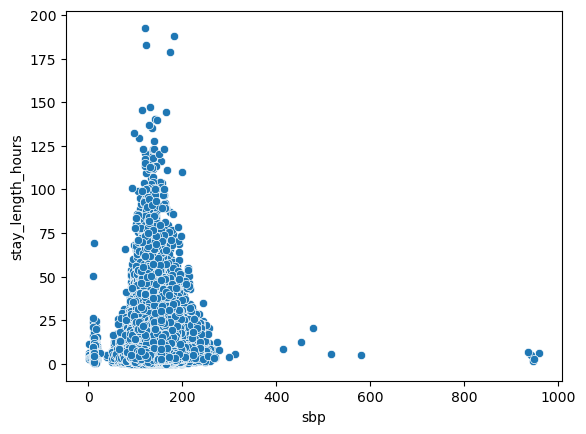

In [21]:
sns.scatterplot(x="sbp",
                    y="stay_length_hours",
                    data=df)

<Axes: xlabel='dbp', ylabel='stay_length_hours'>

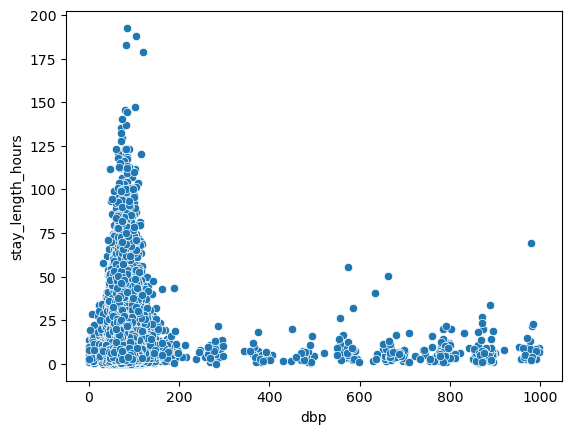

In [22]:
sns.scatterplot(x="dbp",
                    y="stay_length_hours",
                    data=df)

In [23]:
df.isna().sum()

subject_id                    0
hadm_id                  188884
stay_id                       0
intime                        0
outtime                       0
gender                        0
race                          0
arrival_transport             0
language                  88514
admission_age                65
temperature               21203
heartrate                 15158
resprate                  18020
o2sat                     18244
sbp                       16185
dbp                       16965
pain                      11419
acuity                     6183
chiefcomplaint               15
stay_length_hours             0
pain_cleaned_advanced     23821
race_condensed             5889
dtype: int64

In [24]:
print(df['language'].unique())
print(df['language'].value_counts())
print(len(df['language'].unique()))
print(df['language'].isna().sum())

['English' nan 'Spanish' 'Chinese' 'Vietnamese' 'Arabic' 'Haitian'
 'Russian' 'Kabuverdianu' 'Italian' 'Other' 'American Sign Language'
 'Persian' 'Amharic' 'Thai' 'Modern Greek (1453-)' 'Portuguese' 'Khmer'
 'Korean' 'Polish' 'Hindi' 'Bengali' 'French' 'Somali' 'Japanese'
 'Armenian']
language
English                   250396
Spanish                    11916
Russian                     4520
Chinese                     3992
Kabuverdianu                3531
Haitian                     1404
Portuguese                  1274
Other                        644
Vietnamese                   504
Modern Greek (1453-)         489
American Sign Language       483
Italian                      473
Arabic                       356
Persian                      319
Polish                       231
Korean                       175
Amharic                      173
Thai                         172
Somali                       149
French                       119
Khmer                         89
Japanese   

In [25]:
df.groupby('language')['stay_length_hours'].describe()

,count,mean,std,min,25%,50%,75%,max
language,,,,,,,,
American Sign Language,483.0,7.346355,5.909475,0.316667,3.954167,5.800000,8.441667,46.883333
Amharic,173.0,7.785952,6.807767,0.050000,3.646667,5.916667,9.533333,49.700000
Arabic,356.0,7.895314,5.609264,0.850556,4.216667,6.233333,9.250000,32.783333
Armenian,43.0,9.297229,8.964201,1.400000,4.175000,6.566667,9.107639,38.300000
Bengali,80.0,9.906361,7.769919,0.333333,4.954167,6.783333,11.995833,41.266667
Chinese,3992.0,8.191610,6.501125,0.066667,4.414375,6.366667,9.387500,90.900000
English,250396.0,8.124040,7.238694,0.000000,4.100000,6.150972,9.316667,192.566667
French,119.0,7.904283,5.169622,0.066667,5.047083,6.680556,9.450000,32.900000
Haitian,1404.0,8.419661,6.691260,0.083333,4.429167,6.833333,9.883333,56.550000


<Axes: xlabel='admission_age', ylabel='stay_length_hours'>

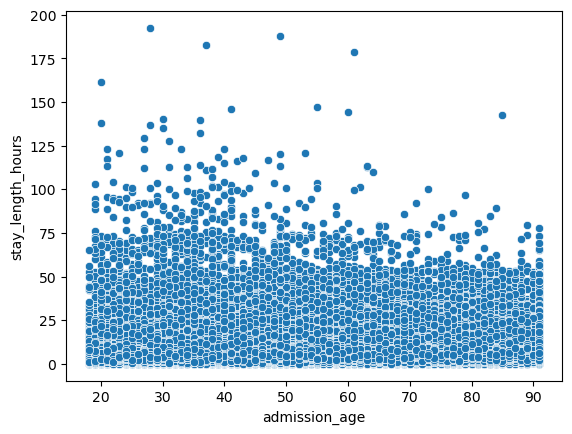

In [26]:
sns.scatterplot(x="admission_age",
                    y="stay_length_hours",
                    data=df)

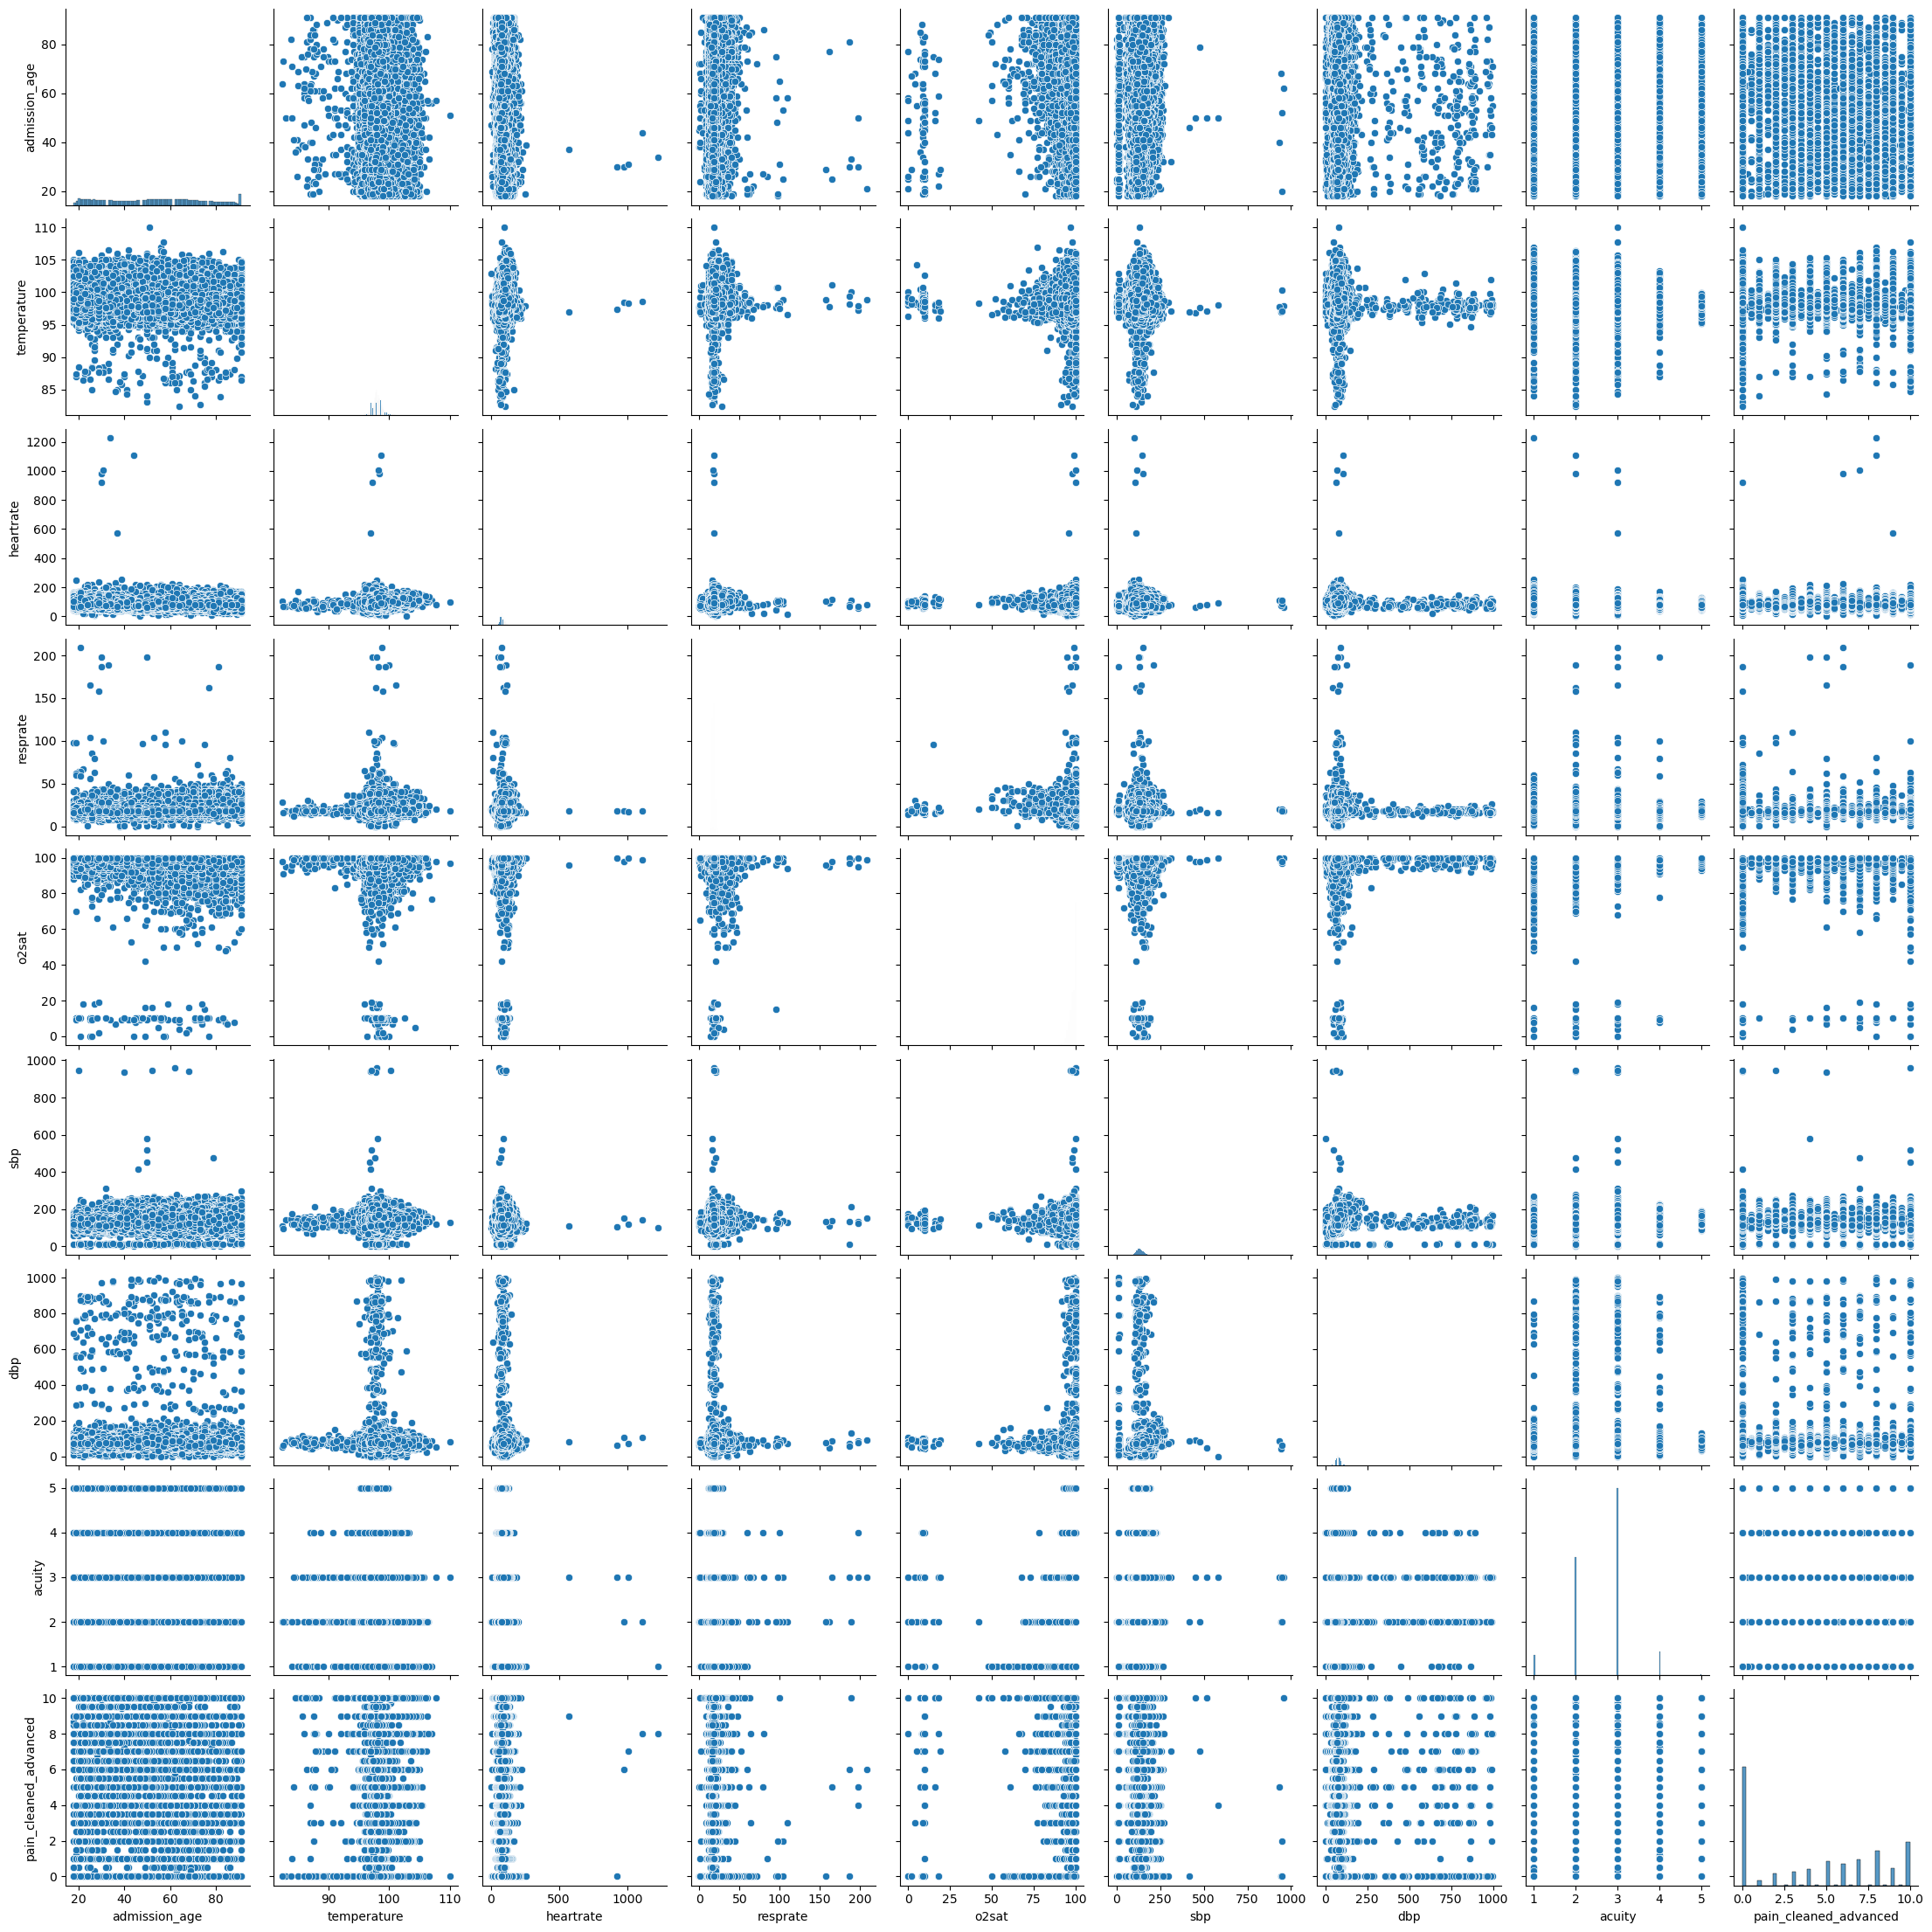

In [27]:
quant_features=['admission_age', 'temperature',
       'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'acuity',
       'pain_cleaned_advanced']
sns.pairplot(df[quant_features])
plt.show()